# Efecto del tamaño de la muestra en validación cruzada

También es importante comprender cómo los diferentes errores están influenciados por el número de muestras disponibles.

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target
target *= 100

In [3]:
data.count()

MedInc        20640
HouseAge      20640
AveRooms      20640
AveBedrms     20640
Population    20640
AveOccup      20640
Latitude      20640
Longitude     20640
dtype: int64

In [4]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(max_depth=10)

## Curva de aprendizaje
Podemos variar el número de muestras en el conjunto de entrenamiento y repetir el experimento. 

Los puntajes de entrenamiento y prueba se pueden trazar de manera similar a la curva de validación, pero en lugar de variar un hiperparámetro, variamos el número de muestras de entrenamiento.

Esta curva se llama **Curva de aprendizaje**.
- Proporciona información sobre el beneficio de agregar nuevas muestras de capacitación para mejorar el rendimiento de generalización de un modelo.

In [5]:
# Calculemos la curva de aprendizaje para un árbol de decisión y variemos la proporción del entrenamiento establecida del 10% al 100%.

import numpy as np
train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)
train_sizes

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [6]:
# usamos validación cruzada ShuffleSplit para evaluar nuestro modelo predictivo.

from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2)

In [7]:
# listos para llevar a cabo el experimento:

from sklearn.model_selection import learning_curve

results = learning_curve(
    regressor, data, target, train_sizes=train_sizes, cv=cv, scoring='neg_mean_absolute_error', n_jobs=2
    )

train_size, train_scores, test_scores = results[:3]


In [8]:
train_errors, test_errors = -train_scores, -test_scores

Text(0.5, 1.0, 'Curva de aprendizaje para el árbol de decisión')

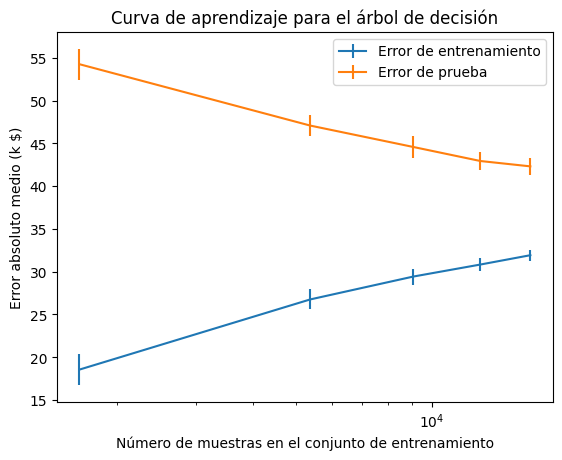

In [9]:
# graficar la curva.

import matplotlib.pyplot as plt

plt.errorbar(train_size, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label="Error de entrenamiento")
plt.errorbar(train_size, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label="Error de prueba")
plt.legend()

plt.xscale("log")
plt.xlabel("Número de muestras en el conjunto de entrenamiento")
plt.ylabel("Error absoluto medio (k $)")
plt.title("Curva de aprendizaje para el árbol de decisión")

- Observando solo el **error de entrenamiento**, vemos que tenemos un error de 0 k$.
    - Significa que el modelo entrenado está claramente sobreajustado los datos.

- Observando solo el **error de prueba**, observamos que cuantas más muestras se agregan al conjunto de entrenamiento, menor será el error de prueba.
    - Además, estamos buscando la meseta del error de prueba para el cual ya no hay beneficio de agregar muestras o evaluar la posible ganancia de agregar más muestras al conjunto de capacitación.
    - Si logramos una meseta y agregar nuevas muestras en el conjunto de entrenamiento no reduce el error de prueba, es posible que hayamos alcanzado la **tasa de error Bayes** utilizando el modelo disponible.
        - Usar de un modelo más complejo podría ser la única posibilidad de reducir aún más el error de prueba.

## **Conclusiones**

- Modelo **sobreajusta**:
    - El número de muestras en el "conjunto de entrenamiento" es demasiado pequeño
    - *El error de prueba es mucho más grande que el error de entrenamiento*

- Modelo **subajusta**:
    - Los modelos no pueden capturar la forma del "conjunto de entrenamiento"
    - *Incluso el error de entrenamiento es grande*

**Diferentes familias de modelos** = Diferente complejidad & sesgo inductivo

## **Ejercicio**

Para el dataset "house-prices/full.csv" y usando Ridge: 

- Encuentra la meseta del error de prueba, donde ya no hay beneficios de añadir más datos al entrenamiento.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
# Carga de datos
haouses = pd.read_csv("../../data/house-prices/full.csv")
haouses.columns
# haouses.shape

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [12]:
haouses['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [13]:
haouses.shape

(1460, 81)

In [14]:
target_name = "SalePrice"

y = haouses[target_name]
X = haouses.drop(columns=target_name)

In [15]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [16]:
# Mostrar información del dataset
print("Características del dataset:")
print(f"- Número de muestras: {X.shape[0]}")
print(f"- Número de características: {X.shape[1]}")
print(f"\nNombres de las características:\n{X.columns}")
print(f"\nDescripción de las características:\n{X.info()}...")

# Ver primeras filas
X.head()

Características del dataset:
- Número de muestras: 1460
- Número de características: 80

Nombres de las características:
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'Gara

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,?,Reg,Lvl,AllPub,...,0,0,?,?,?,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,?,Reg,Lvl,AllPub,...,0,0,?,?,?,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,?,IR1,Lvl,AllPub,...,0,0,?,?,?,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,?,IR1,Lvl,AllPub,...,0,0,?,?,?,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,?,IR1,Lvl,AllPub,...,0,0,?,?,?,0,12,2008,WD,Normal


In [17]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

In [18]:
numerical_columns

['Id',
 'MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [19]:
categorical_columns

['MSZoning',
 'LotFrontage',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [20]:
preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])


In [21]:
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=12))
])

In [22]:
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.2)


In [23]:
import numpy as np
train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)
train_sizes

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [24]:
from sklearn.model_selection import learning_curve

results = learning_curve(
    ridge_pipeline, X, y, train_sizes=train_sizes, cv=cv,
    scoring="neg_mean_absolute_error", n_jobs=2)


train_size, train_scores, test_scores = results[:3]

# Convertir el negativo de los puntajes de error
train_errors, test_errors = -train_scores, -test_scores

Text(0.5, 1.0, 'Curva de aprendizaje para el árbol de decisión')

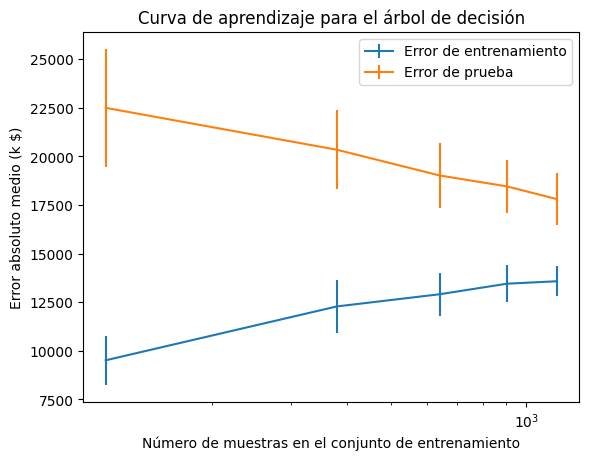

In [25]:
# graficar la curva.

import matplotlib.pyplot as plt

plt.errorbar(train_size, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label="Error de entrenamiento")
plt.errorbar(train_size, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label="Error de prueba")
plt.legend()

plt.xscale("log")
plt.xlabel("Número de muestras en el conjunto de entrenamiento")
plt.ylabel("Error absoluto medio (k $)")
plt.title("Curva de aprendizaje para el árbol de decisión")

> **Saber más:** https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/